In [2]:
import numpy as np
import librosa
import librosa.display
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import os
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [3]:
df_train = pd.read_csv('metadata of train set .csv')
print(df_train.columns)
df_train.head(10)

Index(['Filename', 'File ID', 'Duration in ms', 'Class ID', 'Classname',
       'augmentation  id', 'Augmentation  type', 'source'],
      dtype='object')


,Filename,File ID,Duration in ms,Class ID,Classname,augmentation id,Augmentation type,source
0,108160-1_0_0.wav,108160,3730,0,breath,0,Orignal,https://freesound.org/
1,108160-2_0_0.wav,108160,4000,0,breath,0,Orignal,https://freesound.org/
2,108160-3_0_0.wav,108160,4000,0,breath,0,Orignal,https://freesound.org/
3,108160-4_0_0.wav,108160,2226,0,breath,0,Orignal,https://freesound.org/
4,146769-1_0_0.wav,146769,3540,0,breath,0,Orignal,https://freesound.org/
5,151215_0_0.wav,151215,3690,0,breath,0,Orignal,https://freesound.org/
6,162254-1_0_0.wav,162254,4000,0,breath,0,Orignal,https://freesound.org/
7,162254-2_0_0.wav,162254,4000,0,breath,0,Orignal,https://freesound.org/
8,164101-32_0_0.wav,164101,3860,0,breath,0,Orignal,https://freesound.org/
9,169222-1_0_0.wav,169222,3690,0,breath,0,Orignal,https://freesound.org/


Axes(0.125,0.11;0.775x0.77)
Augmentation  type
Orignal    6289
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6289 entries, 0 to 6288
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Filename        6289 non-null   object
 1   File ID         6289 non-null   object
 2   Duration in ms  6289 non-null   int64 
 3   Class ID        6289 non-null   int64 
 4   Classname       6289 non-null   object
 5   source          6289 non-null   object
dtypes: int64(2), object(4)
memory usage: 294.9+ KB
None


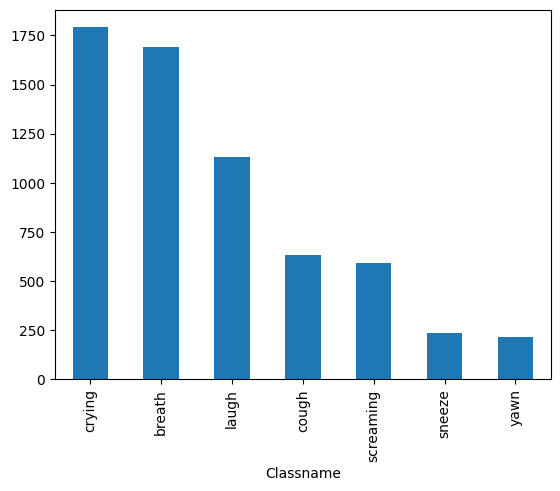

In [4]:
print(df_train['Classname'].value_counts().plot(kind='bar'))
print(df_train['Augmentation  type'].value_counts())
df_train.nunique()
df_train.drop([ 'augmentation  id','Augmentation  type'], axis=1, inplace=True)
print(df_train.info())

In [5]:
df_sample = df_train.groupby('Classname').head(10)
df_sample.reset_index(inplace=True)
df_sample.head(10)

,index,Filename,File ID,Duration in ms,Class ID,Classname,source
0,0,108160-1_0_0.wav,108160,3730,0,breath,https://freesound.org/
1,1,108160-2_0_0.wav,108160,4000,0,breath,https://freesound.org/
2,2,108160-3_0_0.wav,108160,4000,0,breath,https://freesound.org/
3,3,108160-4_0_0.wav,108160,2226,0,breath,https://freesound.org/
4,4,146769-1_0_0.wav,146769,3540,0,breath,https://freesound.org/
5,5,151215_0_0.wav,151215,3690,0,breath,https://freesound.org/
6,6,162254-1_0_0.wav,162254,4000,0,breath,https://freesound.org/
7,7,162254-2_0_0.wav,162254,4000,0,breath,https://freesound.org/
8,8,164101-32_0_0.wav,164101,3860,0,breath,https://freesound.org/
9,9,169222-1_0_0.wav,169222,3690,0,breath,https://freesound.org/


In [63]:
def extract_features(y, sr, n_mfcc=15):
    #Extract multiple features from each sound
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    mfcc_mean = np.mean(mfcc, axis=1)  # Shape: (n_mfcc,)
    delta_mfcc = librosa.feature.delta(mfcc)
    delta_mfcc_mean = np.mean(delta_mfcc, axis=1)  # Shape: (n_mfcc,)
    zcr = np.mean(librosa.feature.zero_crossing_rate(y))  # Shape: (1,)
    rms = np.mean(librosa.feature.rms(y=y))  # Shape: (1,)
    spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))  # Shape: (1,)
    spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))  # Shape: (1,)
    pitches, magnitudes = librosa.piptrack(y=y, sr=sr)
    pitch = np.mean(pitches[pitches > 0]) if np.any(pitches > 0) else 0  # Mean pitch value
    features = np.hstack((
        mfcc_mean, delta_mfcc_mean,  # MFCC & Delta
        [zcr, rms, spectral_centroid, spectral_bandwidth, pitch]  # Other features
    ))
    return features

features = []
labels = []

for i, row in tqdm.tqdm(df_train.iterrows(), desc='Loading : ', total=len(df_train)):
    path = 'train/' + row['Filename']
    y,sr=librosa.load(path)
    extracted_features = extract_features(y,sr)
    features.append(extracted_features)
    labels.append(row['Class ID'])

features = np.array(features)
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)
print("Final Feature Shape:", features_scaled.shape)  # Expected (num_samples, n_mfcc + 1)

Loading : 100%|██████████| 6289/6289 [08:15<00:00, 12.68it/s]

Final Feature Shape: (6289, 35)


In [64]:
ffeat=features_scaled
lbls=labels

In [65]:
features_scaled=ffeat
labels=lbls

In [67]:
import torch
import numpy as np
from torch.nn.functional import one_hot

X = np.array(features_scaled)
y = np.array(labels)

print(X.shape, y.shape)
print('Done')

(6289, 35) (6289,)
Done


In [228]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define a deep CNN + LSTM model
class CNN_LSTM_Model(nn.Module):
    def __init__(self, input_size=35, num_classes=10, lstm_hidden=128, lstm_layers=3, cnn_filters=64):
        super(CNN_LSTM_Model, self).__init__()

        # CNN Feature Extractor
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=cnn_filters, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=cnn_filters, out_channels=cnn_filters * 2, kernel_size=3, padding=1)
        # self.conv3 = nn.Conv1d(in_channels=cnn_filters * 2, out_channels=cnn_filters * 4, kernel_size=3, padding=1)

        # MaxPool1d - Ensuring it doesn't zero out everything
        self.pool = nn.MaxPool1d(kernel_size=2, stride=1)  # Ensure stride doesn't collapse dimensions

        # BatchNorm
        self.bn1 = nn.BatchNorm1d(cnn_filters)
        self.bn2 = nn.BatchNorm1d(cnn_filters * 2)
        # self.bn3 = nn.BatchNorm1d(cnn_filters * 4)

        # LSTM for sequential modeling
        self.lstm = nn.LSTM(input_size=cnn_filters * 2, hidden_size=lstm_hidden, num_layers=lstm_layers, batch_first=True, bidirectional=True)

        # Fully Connected Layer
        self.fc = nn.Linear(lstm_hidden * 2, num_classes)  # Bidirectional LSTM doubles the hidden size

    def forward(self, x):
        x = x.unsqueeze(1)  # Adding channel dimension for Conv1d

        # CNN feature extraction
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        # x = self.pool(F.relu(self.bn3(self.conv3(x))))

        x = x.permute(0, 2, 1)  # Rearrange for LSTM (batch, seq, features)

        # LSTM
        x, _ = self.lstm(x)

        # Take last timestep's output
        x = x[:, -1, :]

        # Fully connected layer
        x = self.fc(x)
        return x

# Initialize model
num_classes = 10  # Change this to match your dataset
model = CNN_LSTM_Model(num_classes=num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Using device: cuda


In [229]:
import torch
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.utils import shuffle
from torch.utils.data import TensorDataset, DataLoader

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Convert to NumPy
X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.int64)  # Assuming y is not one-hot encoded

# Shuffle data
X, y = shuffle(X, y, random_state=42)

# Apply SMOTE to balance classes
smote = SMOTE(sampling_strategy='not majority', random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X, y)

# Convert NumPy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train_sm, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_sm, dtype=torch.long).to(device)

# X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
# y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

# Create DataLoader
batch_size = 64
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Training dataset size: {len(train_loader.dataset)}")


Using device: cuda
Training dataset size: 12537


In [230]:
from collections import Counter
print("Before SMOTE:", Counter(y))
print("After SMOTE:", Counter(y_train_sm))


Before SMOTE: Counter({2: 1791, 0: 1690, 3: 1133, 1: 632, 4: 593, 5: 236, 6: 214})
After SMOTE: Counter({6: 1791, 0: 1791, 2: 1791, 3: 1791, 4: 1791, 1: 1791, 5: 1791})


In [231]:
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_acc = correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss:.4f}, Train Accuracy: {train_acc:.4f}")

# ------------------------------

Epoch [1/10], Loss: 286.6233, Train Accuracy: 0.4255
Epoch [2/10], Loss: 220.1233, Train Accuracy: 0.5682
Epoch [3/10], Loss: 193.8686, Train Accuracy: 0.6261
Epoch [4/10], Loss: 175.9681, Train Accuracy: 0.6611
Epoch [5/10], Loss: 155.2708, Train Accuracy: 0.7084
Epoch [6/10], Loss: 137.7112, Train Accuracy: 0.7389
Epoch [7/10], Loss: 119.5840, Train Accuracy: 0.7762
Epoch [8/10], Loss: 106.1221, Train Accuracy: 0.8063
Epoch [9/10], Loss: 95.9450, Train Accuracy: 0.8209
Epoch [10/10], Loss: 81.0516, Train Accuracy: 0.8482


In [232]:
model.eval()
train_features, train_labels = [], []
test_features, test_labels = [], []

with torch.no_grad():
    for inputs, labels in train_loader:
        features = model(inputs)
        train_features.append(features.cpu().numpy())
        train_labels.append(labels.cpu().numpy())

    for inputs, labels in test_loader:
        features = model(inputs)
        test_features.append(features.cpu().numpy())
        test_labels.append(labels.cpu().numpy())

train_features = np.vstack(train_features)
train_labels = np.hstack(train_labels)
test_features = np.vstack(test_features)
test_labels = np.hstack(test_labels)

print(f"Feature Extraction Complete! Train Shape: {train_features.shape}, Test Shape: {test_features.shape}")


Feature Extraction Complete! Train Shape: (12537, 10), Test Shape: (725, 10)


In [233]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, f1_score, accuracy_score
# ---------------------- TRAIN SVM ----------------------
svm_model = make_pipeline(StandardScaler(), SVC(kernel='rbf', C=1, gamma='scale'))
svm_model.fit(train_features, train_labels)

# ---------------------- EVALUATION ----------------------
svm_preds = svm_model.predict(test_features)

accuracy = accuracy_score(test_labels, svm_preds)
f1 = f1_score(test_labels, svm_preds, average='macro')
classification_rep = classification_report(test_labels, svm_preds)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Classification Report:\n", classification_rep)

Test Accuracy: 0.4524
F1 Score: 0.4179
Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.67      0.61       160
           1       0.38      0.49      0.43        70
           2       0.54      0.40      0.46       205
           3       0.36      0.27      0.31       140
           4       0.43      0.64      0.52        70
           5       0.53      0.27      0.36        30
           6       0.21      0.30      0.25        50

    accuracy                           0.45       725
   macro avg       0.43      0.43      0.42       725
weighted avg       0.46      0.45      0.45       725



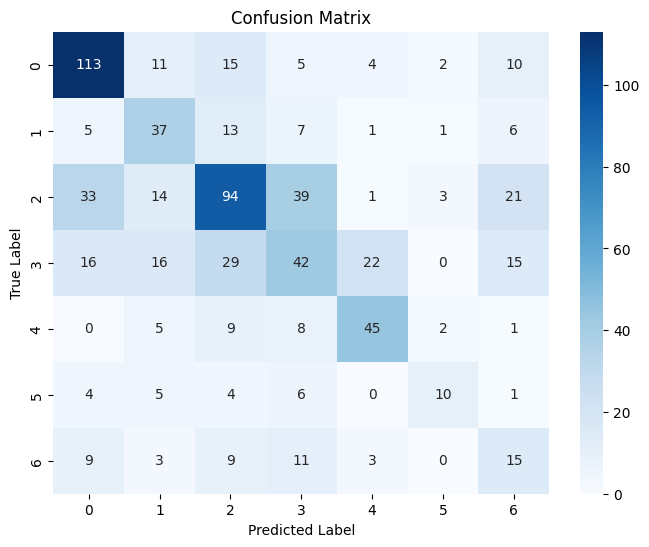

In [204]:
from sklearn.metrics import (
    classification_report)
conf_matrix = confusion_matrix(test_labels, svm_preds)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(test_labels), yticklabels=np.unique(test_labels))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [49]:
df_test =pd.read_csv('metadata of test set.csv')
df_test.drop([ 'Augment Id','Augmentation type'], axis=1, inplace=True)
df_test.head(5)

,Filename,File_ID,Durationin ms,Class_id,Classname,source
0,112557-2_0_0.wav,112557,4000,0,breath,https://freesound.org/
1,112557-3_0_0.wav,112557,3950,0,breath,https://freesound.org/
2,112557-4_0_0.wav,112557,3910,0,breath,https://freesound.org/
3,140301_0_0.wav,140301,2261,0,breath,https://freesound.org/
4,144128-1_0_0.wav,144128,3770,0,breath,https://freesound.org/


In [50]:
features_test = []
labels_test = []

for i, row in tqdm.tqdm(df_test.iterrows(), desc='Loading : ', total=len(df_test)):
    path = 'test/' + row['Filename']
    y,sr=librosa.load(path)
    extracted_features_test = extract_features(y,sr)
    features_test.append(extracted_features_test)
    labels_test.append(row['Class_id'])

# Convert to NumPy array
features_test = np.array(features_test)

# Standardize the features_test
scaler = StandardScaler()
features_test_scaled = scaler.fit_transform(features_test)

print("Final Feature Shape:", features_test_scaled.shape) 

Loading : 100%|██████████| 725/725 [01:12<00:00,  9.96it/s]

Final Feature Shape: (725, 35)


In [189]:
X_test =features_test_scaled
y_test =labels_test
X_test = np.array(X_test) 
y_test = np.array(y_test) 


In [190]:
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

# Create DataLoader
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
